In [1]:
from IPython.display import display
from IPython.display import Image
import os
from utils import * # Code shared across more than one notebook

In [2]:
output_path = "2-output_data/"

if not os.path.exists(output_path):
    os.mkdir(output_path)

# gVirtualXray vs DRRs

**Main contributors:** J. Pointon, J. Tugwell-Allsup and F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to digitally reconstructed radiographs (DRRs) of a real CT scan computed with [Plastimatch](https://plastimatch.org/).

**Material and Methods:** For this experiment, we attempt to recreate a X-ray projections of the [Lungman chest phantom](https://www.kyotokagaku.com/en/products_data/ph-1_01/) with gVirtualXRay. 

1. The CT of a chest phantom has been generated from a real scanner ahead of time. 
| Lungman phantom | 3D model |
|-----------------|----------|
| ![Photogram of the Lungman phantom](lungman_data/lungman.png) | ![Visualisation of the 3D model of the Lungman phantom](2-output_data/lungman_model.png) |
2. Structures in the reference CT have been segmented and labelled. 
3. The resultant surfaces from the segmentations form a virtual lungman model. 
4. We use gVirtualXRay to simulate X-ray projection on this model and 
5. compare the result with Digitally Reconstructed Radiographs (DRRs) of the original CT scan.

![Workflow of this study.](doc/lungman-validation-DRR-flow.png)

**Results:** Images generated with gVirtualXray are very similar to DRRs computed with Plastimatch, despite the use of homogeneous materials in the simulation. 
MAPE is low in both cases (2.01% and 2.66%), ZNCC (99.65% and 99.36%) and SSIM (0.98 and 0.93) are high in both cases. 
It took 442 ms to compute the DRR images on GPU with Plastimatch compiled with CUDA, 29 ms with gVirtualXray. 
It corresponds to a 15x speedup.

| | RL view | AP view |
|-|--------|---------|
| | ![](2-output_data/lungman-compare-projs-plastimatch-rl.png) | ![](2-output_data/lungman-compare-projs-plastimatch-ap.png) |
| **MAPE:** | 2.01% | 2.66% |
| **ZNCC:** | 99.65% | 99.36% |
| **SSIM:** | 0.98 | 0.92 |

The calculations were performed on the following platform:

In [3]:
printSystemInfo()

OS:
	Linux 5.3.18-150300.59.54-default
	x86_64

CPU:
 	AMD Ryzen 7 3800XT 8-Core Processor

RAM:
	63 GB
GPU:
	Name: NVIDIA GeForce RTX 2080 Ti
	Drivers: 510.73.08
	Video memory: 11 GB


# Import packages

In [4]:
%matplotlib inline

import SimpleITK as sitk
import pandas as pd
import numpy as np
import numpy.ma as ma # Masking
from utils import *
from convertRaw import *
from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr
from gvxrPython3.utils import visualise

import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'serif'#,
        #'weight' : 'bold',
         # 'size'   : 22
       }
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)

import plotly.express as px

from tifffile import imread, imwrite # Load/Write TIFF file

from sitk2vtk import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
import skimage

#import scipy
import os
import math
import zipfile
import datetime

import imageio

import random
import base64
from time import sleep

SimpleGVXR 2.0.3 (2022-10-22T20:40:00) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.3 (2022-10-22T20:39:59) [Compiler: GNU g++] on Linux


In [5]:
SAVE_DATA = True
GENERATE_NEW_DATA_ALWAYS = False
DO_K3D_PLOT = True

In [6]:
DO_ARTEFACT_FILTERING_ON_GPU = True
DO_ARTEFACT_FILTERING_ON_CPU = False
number_of_projections = 1000
angular_step = 180 / number_of_projections

# Configure gVirtualXRay environment

## Create an OpenGL context and window

In [7]:
json2gvxr.initGVXR("notebook-2.json", "OPENGL")

Create an OpenGL context: 512x512


Tue Jan 10 21:31:27 2023 ---- Create window (ID: -1)
Tue Jan 10 21:31:27 2023 ---- Initialise GLFW
Tue Jan 10 21:31:27 2023 ---- Create an OpenGL window with a 3.2 context.
Tue Jan 10 21:31:27 2023 ---- Make the window's context current
Tue Jan 10 21:31:27 2023 ---- Initialise GLEW
Tue Jan 10 21:31:27 2023 ---- OpenGL vendor: NVIDIA Corporation
Tue Jan 10 21:31:27 2023 ---- OpenGL renderer: NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
Tue Jan 10 21:31:27 2023 ---- OpenGL version: 3.2.0 NVIDIA 510.73.08
Tue Jan 10 21:31:27 2023 ---- Use OpenGL 4.5.
Tue Jan 10 21:31:27 2023 ---- Initialise the X-ray renderer if needed and if possible


## Create a parallel photon beam

In [8]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


## Create a monochromatic spectrum

In [9]:
json2gvxr.initSpectrum();

**Create a detector array.**

In [10]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Number of pixels: [725, 426]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 1.0, 'mm']


Tue Jan 10 21:31:30 2023 ---- Initialise the renderer


In [11]:
# nb_pixels = gvxr.getDetectorNumberOfPixels()
# detector_size = gvxr.getDetectorSize("mm")
pixel_width = json2gvxr.params["Detector"]["Spacing"][0]
pixel_height = json2gvxr.params["Detector"]["Spacing"][1]

# Load the CT scan

In [12]:
# Read the reference CT
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");
sitk_reader.SetFileName("lungman_data/lungman.mha")
raw_ground_truth = sitk_reader.Execute()
raw_ground_truth.SetSpacing([pixel_width,
                             pixel_width,
                             pixel_height
                            ])

# Make sure each volume has floating point precision
real_CT_in_HU = sitk.GetArrayFromImage(raw_ground_truth).astype(np.single)
del sitk_reader
del raw_ground_truth

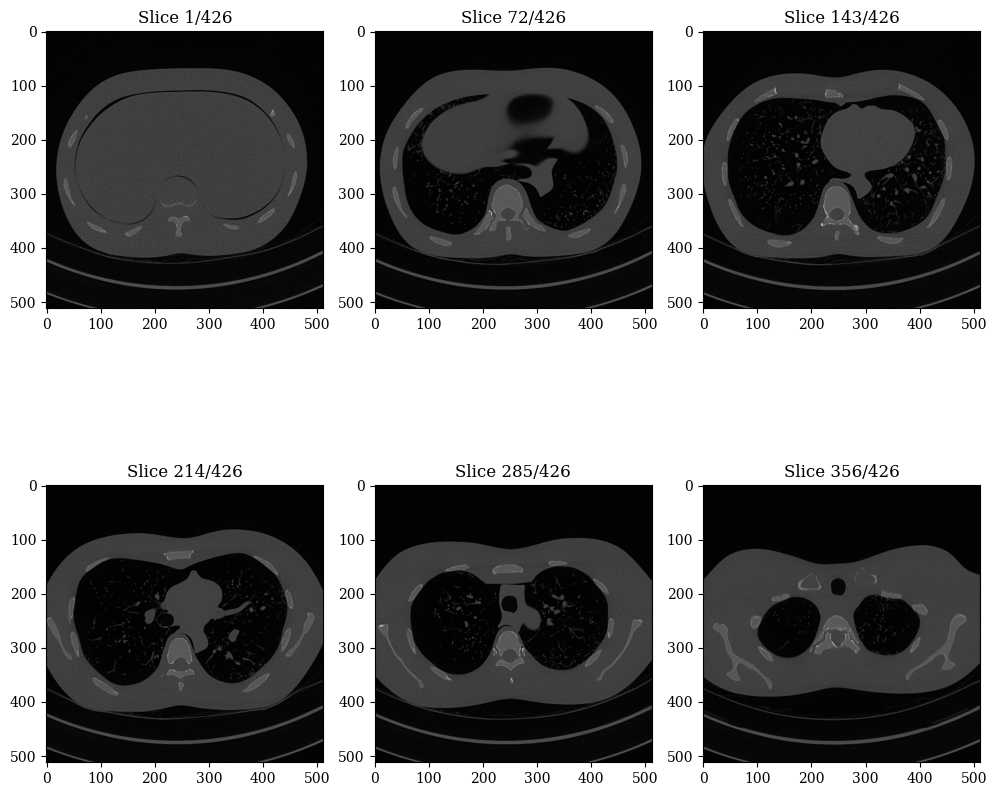

In [13]:
ncols = 3
nrows = 2

step = int(real_CT_in_HU.shape[0] / (ncols * nrows))
slices = range(0, int(real_CT_in_HU.shape[0]), step)

fig = plt.figure(figsize= (10,10))

ct_min_val = real_CT_in_HU.min()
ct_max_val = real_CT_in_HU.max()

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(real_CT_in_HU.shape[0]))
        ax.imshow(real_CT_in_HU[slice_id], cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig(output_path + '/lungman-real_CT_in_HU.pdf', bbox_inches = 'tight')
plt.savefig(output_path + '/lungman-real_CT_in_HU.png', bbox_inches = 'tight')

In [14]:
def ShouldGenerateNew(*fnames):
    
    if (GENERATE_NEW_DATA_ALWAYS):
        return True
    
    for fname in fnames:
        if (not os.path.exists(fname)):
            return True
        
    return False

# Convert ground truth from HU to &mu;

In [15]:
fname = output_path + "/lungman-real_CT_in_mu.mha"

if ShouldGenerateNew(fname):

    #real_CT_in_mu = np.array(gvxr.convertHU2mu(real_CT_in_HU, ray_energy, "keV"))
    mu_air = gvxr.getMuFromHU(-1000.0, 72, "keV");
    mu_water  =gvxr.getMuFromHU(0.0, 72, "keV");
    real_CT_in_HU = real_CT_in_HU.astype(np.double);
    real_CT_in_mu = ((real_CT_in_HU / 1000.0 ) * (mu_water - mu_air)) + mu_water;
  
   
    if SAVE_DATA:
      
        sitk_real_CT_in_mu = sitk.GetImageFromArray(real_CT_in_mu)
        sitk_real_CT_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])

        sitk_real_CT_in_mu.SetOrigin((-pixel_width * real_CT_in_mu.shape[2] / 2.0,
                              -pixel_width * real_CT_in_mu.shape[1] / 2.0,
                              -pixel_height * real_CT_in_mu.shape[0] / 2.0))
    
        sitk.WriteImage(sitk_real_CT_in_mu, fname, useCompression=True)

else:
    sitk_real_CT_in_mu = sitk.ReadImage(fname)
    sitk_real_CT_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])
    real_CT_in_mu = sitk.GetArrayFromImage(sitk_real_CT_in_mu)
    
del sitk_real_CT_in_mu

# Extract data for this experiment
The labelled volumes are provided compressed in a zip file. Use this procedure to extract the surfaces and masks needed for this notebook.

In [16]:
# Uncompress the labels
if (False == os.path.isfile("./lungman_data/segmentation-uncompressed/labels.mha")):
    with zipfile.ZipFile(  "./lungman_data/segmentation-compressed.zip", 'r') as myzip:
        myzip.extractall(  "./lungman_data/segmentation-uncompressed")

# Read the records for isovalue, average HU
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read labels
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha";
phantom = sitk.ReadImage(label_rel_path)
phantom.SetSpacing([pixel_width, pixel_width, pixel_height])
phantom_array = sitk.GetArrayFromImage(phantom)

In [17]:
# rd = vtk.vtkMetaImageReader();
# rd.SetFileName(label_rel_path);
# rd.Update()
# vtkLabels = rd.GetOutput();

# Create threshold filter
# threshold = vtk.vtkImageThreshold();
# threshold.SetInputData(vtkLabels);
# threshold.SetReplaceOut(0);
# threshold.ReplaceOutOn()
# threshold.ReplaceInOff();

fname_HU = output_path + "/lungman-ground_truth2-CT-in_HU.mha"
fname_mu = output_path + "/lungman-ground_truth2-CT-in_mu.mha"

ref_data = {}

if ShouldGenerateNew(fname_HU, fname_mu):
    digital_phatom_in_HU = np.zeros(phantom_array.shape, dtype=np.int16) - 1000
    digital_phatom_in_mu = np.zeros(phantom_array.shape, dtype=np.single)
else:
    sitk_digital_phatom_in_HU = sitk.ReadImage(fname_HU)
    sitk_digital_phatom_in_HU.SetSpacing([pixel_width, pixel_width, pixel_height])
    digital_phatom_in_HU = sitk.GetArrayFromImage(sitk_digital_phatom_in_HU)

    sitk_digital_phatom_in_mu = sitk.ReadImage(fname_mu)
    sitk_digital_phatom_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])
    digital_phatom_in_mu = sitk.GetArrayFromImage(sitk_digital_phatom_in_mu)    
    
for i in range(0, len(split_lines)):
    tuple_parts = split_lines[i].split('\t');
    
    if len(tuple_parts) == 3:

        structure_name = tuple_parts[2][0:-4]
        structure_isovalue = int(tuple_parts[0])

        print("Process", structure_name)

        # See if the surface already exists
        stl_rel_path = "./lungman_data/meshes/" + tuple_parts[2][0:-4] + ".stl";
        # if (True == os.path.isfile(stl_rel_path)): continue;

        # Threshold to get label
    #     threshold.ThresholdBetween(structure_isovalue, structure_isovalue);
    #     threshold.Update();
    #     vtkIm = threshold.GetOutput();

    #     # Extract surface and save
    #     vtkSurface = extractSurface(vtkIm, structure_isovalue);
    #     writeSTL(vtkSurface, stl_rel_path);
    #     vtkSurface = None;
    #     vtkIm = None;    

        # Threshold the phantom
        binary_mask = (phantom == structure_isovalue)
        binary_mask_before_padding_array = sitk.GetArrayFromImage(binary_mask)

        # Pad the image
        filt = sitk.ConstantPadImageFilter()
        filt.SetConstant (0)
        filt.SetPadLowerBound ([1, 1, 1])
        filt.SetPadUpperBound ([1, 1, 1])
        binary_image = filt.Execute(binary_mask)               

        # Create a VTK image
        binary_array = sitk.GetArrayFromImage(binary_image)
        vtkimg = sitk2vtk(binary_image, centre=True)

        # binary_array = sitk.GetArrayFromImage(binary_image)
        min_val = binary_array.min()
        max_val = binary_array.max()

        threshold = min_val + 0.5 * (max_val - min_val)

        vtkmesh = extractSurface(vtkimg, threshold)
        del vtkimg

        writeSTL(vtkmesh, stl_rel_path)
        del vtkmesh


        # Get HU/mu

        if ShouldGenerateNew(fname_HU, fname_mu):

            kernel_radius = 2;

            # Sheets are too slim to be eroded so much
            if (structure_name.find("sheet") != -1):
                kernel_radius = 1;

            # Erode the mask
            erode = sitk.BinaryErodeImageFilter();
            erode.SetKernelRadius(kernel_radius);
            erode.SetForegroundValue(1);
            sitk_eroded_mask = erode.Execute(binary_mask);
            del erode

            eroded_mask = np.array(sitk.GetArrayFromImage(sitk_eroded_mask));
            del sitk_eroded_mask

            # Apply mask to simulated CT
            erored_test = (eroded_mask == 1)

            test = phantom_array == structure_isovalue

            avg_HU = np.mean(real_CT_in_HU[erored_test])
            avg_mu = np.mean(real_CT_in_mu[erored_test])

            if np.isnan(avg_HU):
                avg_HU = np.mean(real_CT_in_HU[binary_mask_before_padding_array == 1])
                avg_mu = np.mean(real_CT_in_mu[binary_mask_before_padding_array == 1])

            print("\t\t\"Material\": [\"HU\",", avg_HU, "]")

            ref_data[structure_name] = [avg_HU, avg_mu]
            digital_phatom_in_HU[test] = round(avg_HU)
            digital_phatom_in_mu[test] = avg_mu
        
del phantom
del real_CT_in_HU

Process bronchioles
Process bronchus
Process trachea
Process diaphram
Process skin
Process heart
Process sheets_low
Process sheets_med
Process sheets_high
Process tumours_630HU
Process tumours_100HU
Process spine-hard-500
Process spine-soft-500
Process scaps-hard-450
Process scaps-soft-450
Process sternum-hard-450
Process sternum-soft-450
Process clavicle-hard-600
Process clavicle-soft-600


In [18]:
if ShouldGenerateNew(fname_HU, fname_mu):
    
    if SAVE_DATA:
        sitk_digital_phatom_in_HU = sitk.GetImageFromArray(digital_phatom_in_HU)

        sitk_digital_phatom_in_HU.SetOrigin((-pixel_width * digital_phatom_in_HU.shape[2] / 2.0,
                      -pixel_width * digital_phatom_in_HU.shape[1] / 2.0,
                      -pixel_height * digital_phatom_in_HU.shape[0] / 2.0))

        sitk_digital_phatom_in_HU.SetSpacing([pixel_width, pixel_width, pixel_height])
        sitk.WriteImage(sitk_digital_phatom_in_HU, fname_HU, useCompression=True)
        del sitk_digital_phatom_in_HU


        sitk_digital_phatom_in_mu = sitk.GetImageFromArray(digital_phatom_in_mu)

        sitk_digital_phatom_in_mu.SetOrigin((-pixel_width * digital_phatom_in_mu.shape[2] / 2.0,
                     -pixel_width * digital_phatom_in_mu.shape[1] / 2.0,
                      -pixel_height * digital_phatom_in_mu.shape[0] / 2.0))

        sitk_digital_phatom_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])
        sitk.WriteImage(sitk_digital_phatom_in_mu, fname_mu, useCompression=True)
        del sitk_digital_phatom_in_mu

del digital_phatom_in_mu
del digital_phatom_in_HU

## Create a phantom model from each mesh and its material

In [19]:
json2gvxr.initSamples();

Tue Jan 10 21:32:32 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-validation/lungman_data/meshes/bronchioles.stl	nb_faces:	5338192	nb_vertices:	16014576	bounding_box (in cm):	(-12.625, -8.3125, -19.5)	(11.8125, 7.3125, 18.3)
Tue Jan 10 21:32:32 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-validation/lungman_data/meshes/bronchus.stl	nb_faces:	701200	nb_vertices:	2103600	bounding_box (in cm):	(-11.375, -8.0625, -17.1)	(11.75, 6.5, 15.1)
Tue Jan 10 21:32:32 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-validation/lungman_data/meshes/trachea.stl	nb_faces:	88328	nb_vertices:	264984	bounding_box (in cm):	(-2.8125, -6.625, -2.4)	(3.8125, 0.5, 21.2)
Tue Jan 10 21:32:32 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-validation/lungman_data/meshes/diaphram.stl	nb_faces:	507436	nb_vertices:	1522308	bounding_box (in cm):	(-12.625, -9, -21.2)	(11.875, 6.3125, -11.8)
Tue Jan 10 21:32:33 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-validati

In [20]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh
    
print("There are", f"{number_of_triangles:,}", "triangles in total")

There are 27,756,160 triangles in total


## Visualise the virtual patient

In [ ]:
if (DO_K3D_PLOT):
    plot = visualise(use_log=True, use_negative=True, sharpen_ksize=2, sharpen_alpha=1.0)

In [ ]:
fname = output_path + '/lungman_model.png'
if DO_K3D_PLOT and ShouldGenerateNew(fname):

        
    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)
        fp.flush();
        fp.close();

## Visualise a single projection

In [ ]:
gvxr.computeXRayImage()
gvxr.displayScene()

# Give each mesh an alpha value
alpha = 0.2;
for i in range(gvxr.getNumberOfChildren('root')):
    label = gvxr.getChildLabel('root', i);
    pRGBA = gvxr.getAmbientColour(label);
    gvxr.setColour(label, pRGBA[0], pRGBA[1], pRGBA[2],alpha);

gvxr.useLighing(False)
gvxr.useWireframe(False)
gvxr.setZoom(1000)
gvxr.setSceneRotationMatrix([ 0.8535534,  0.5000000, -0.1464466,0,
  -0.5000000,  0.7071068, -0.5000000,0,
  -0.1464466,  0.5000000,  0.8535534,0,
                            0.0, 0.0, 0.0, 1.0])
gvxr.displayScene()


screenshot = gvxr.takeScreenshot()

plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

In [ ]:
%%capture
runtimes = []
fname = output_path + "/lungman_flat.mha"
if ShouldGenerateNew(fname):


    gvxr.disableArtefactFiltering()

    if DO_ARTEFACT_FILTERING_ON_GPU:
        gvxr.enableArtefactFilteringOnGPU()
    elif DO_ARTEFACT_FILTERING_ON_CPU:
        gvxr.enableArtefactFilteringOnCPU()

    temp = [];
    angles = [];
    runtimes = []

    # Create a GIF file
    writer = None
    fname_gif = output_path + "/lungman_acquisition.gif"

    if not os.path.exists(fname_gif):
        writer = imageio.get_writer(fname_gif, mode='I')

    # Save the transformation matrix
    transformation_matrix_backup = gvxr.getSceneTransformationMatrix()

    rotation_axis = json2gvxr.params["Detector"]["UpVector"]

    for angle_id in range(0, number_of_projections):

        # Add the rotation angle, starting from 0
        angles.append(angle_id * angular_step)

        # Compute an X-ray image
        # xray_image = np.array(gvxr.computeXRayImage());
        start_time = datetime.datetime.now()

        xray_image = np.array(gvxr.computeXRayImage()).astype(np.single)

        # if xray_image.shape != [208, 1062]:
        #     xray_image = resize(xray_image, [208, 1062])

        # xray_image = np.array(gvxr.computeXRayImage());

        end_time = datetime.datetime.now()
        delta_time = end_time - start_time
        runtimes.append(delta_time.total_seconds() * 1000)

        # Add to the set of projections
        temp.append(xray_image)

        # Update the rendering
        gvxr.displayScene();

        # Take a screenshot
        if writer is not None:
            if not angle_id % 30:
                screenshot = gvxr.takeScreenshot()

                plt.figure(figsize= (10,10))
                plt.title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(screenshot)
                plt.axis('off')

                plt.tight_layout()

                plt.savefig('temp.png', bbox_inches = 'tight')            
                plt.close()


                image = imageio.imread("temp.png")
                writer.append_data(image)

        # Rotate the sample
        gvxr.rotateScene(angular_step, rotation_axis[0], rotation_axis[1], rotation_axis[2])

    # We're done with the writer
    if writer is not None:
        writer.close()
        os.remove("temp.png")

    # Convert to numpy arrays
    raw_projections = np.array(temp).astype(np.single)
    del temp
    
    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(transformation_matrix_backup)

    # Update the rendering
    gvxr.displayScene();

In [ ]:
if (len(runtimes) > 0):
    runtime_avg = round(np.mean(runtimes))
    runtime_std = round(np.std(runtimes))
else:
    runtime_avg = -1;
    runtime_std = 0;

In [ ]:
with open(output_path + '/lungman_acquisition.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=500))

# Correct flat-field

Taking advantage of the detector response when there is no sample can help improve the quality of images when a sample is present. To elaborate, any variance between pixels when the detector is dark (X-Ray beam off) or full (X-Ray beam on) with no density will affect the quality of images with a sample. Factoring for this systematic error is called flat-field correction. \
N: corrected image\
P: projection\
D: dark field\
F: full field\
$N = \frac{P - D}{F - D}$\
In this routine the projection data is flat-fielded.



In [ ]:
if ShouldGenerateNew(fname):
    
    corrected_projections = flatFieldCorrection(raw_projections)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(corrected_projections)
        sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, fname, useCompression=True)
    
    del raw_projections # Not needed anymore
    
else:
    temp = sitk.ReadImage(fname)
    temp.SetSpacing([pixel_width, pixel_width, pixel_height])    
    corrected_projections = sitk.GetArrayFromImage(temp).astype(np.single)
    
    angles = np.linspace(0, angular_step * (number_of_projections - 1), number_of_projections)
    


# Negative log normalisation

In [ ]:
fname = output_path + "/lungman_minus_log_projs.mha"

if ShouldGenerateNew(fname):

    minus_log_projs = minusLog(corrected_projections).astype(np.single)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(minus_log_projs)
        sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    temp.SetSpacing([pixel_width, pixel_width, pixel_height])
    minus_log_projs = sitk.GetArrayFromImage(temp).astype(np.single)
    
del corrected_projections # Not needed anymore

Display the images

In [ ]:
proj_min = minus_log_projs.min()
proj_max = minus_log_projs.max()

Draw the projection

In [ ]:
ncols = 4
nrows = 2

step = int(minus_log_projs.shape[0] / (ncols * nrows))
slices = range(0, int(minus_log_projs.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(minus_log_projs.shape[0]) + "\nat $" + "{:.2f}".format(angles[slice_id]) + "\degree$")
        ax.imshow(skimage.transform.rotate(minus_log_projs[slice_id], 180),
                  cmap='gray',
                  vmin=proj_min,
                  vmax=proj_max)

plt.tight_layout()


plt.savefig(output_path + '/lungmand-simulated-projs.pdf', bbox_inches = 'tight')
plt.savefig(output_path + '/lungmand-simulated-projs.png', bbox_inches = 'tight')

## Optimise Plastimatch centre
**Use objective function to find optimimum centre. i.e. register the DRR onto the radiograph**

In [ ]:
from pymoo.util.misc import stack
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from threading import Thread
from sklearn.metrics import mean_absolute_percentage_error

def normImage(image_to_normalise):
    image_to_normalise -= np.mean(image_to_normalise);
    stddev = np.std(image_to_normalise);
    if (stddev == 0): stddev = 0.0001;
    image_to_normalise/= stddev;
    
def measure(truth, predict):
    N = 1.0;
    dims = np.shape(truth);
    for i in range(0, len(dims)):
        N *= dims[i];
    if (N == 0): return -1, -1, -1, -1, -1;
    
    zncc_denom = N * np.std(truth) * np.std(predict);
    if (zncc_denom == 0): zncc_denom = 0.00001;
        
    sub = truth - predict;
    
    mae_score = np.sum(np.abs(sub)) / N;
    zncc_score =  np.sum( (truth  - np.mean(truth)) *(predict - np.mean(predict))) / zncc_denom;
    rmse_score =  np.sqrt(np.sum(np.power(sub, 2)) / N)
    mape_score = mean_absolute_percentage_error(truth, predict);
    ssim_score = ssim(truth, predict);
    return mae_score, zncc_score, rmse_score, mape_score, ssim_score

def objective(cx, cy):
        DRR = doLungmanDRRNumpy(g_NRM[0], g_NRM[1], g_NRM[2], 
                           cx, cy, 
                            "DRR_", 
                            g_XRay.shape[1], g_XRay.shape[0]
                            
                           );
        DRR = DRR.astype(np.single);
        normImage(DRR);
        mae, zncc, rmse, mape, ssim = measure(g_XRay, DRR);
        
        dzncc = (1.0 - zncc) / 2.0
        dssim = (1.0 - ssim) / 2.0

        
        row = []
    
        row.append(mae);
        row.append(dzncc);
        row.append(rmse);
        row.append(mape);
        row.append(dssim);
        return row;

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=5,
                         n_constr=0,
                         xl=np.array([0, -g_XRay.shape[0]]),
                         xu=np.array([g_XRay.shape[1],0])
                         )
    
  
      
    
    def _evaluate(self, X, out, *args, **kwargs):
            objs = []
            for tuple in X:
                objs.append(objective(tuple[0], tuple[1]));

            out["F"] = objs;
        
        
import time
from pymoo.algorithms.moo.nsga2 import NSGA2


algorithm = NSGA2(pop_size=50)

#normImage(xray_AP);
#normImage(xray_RL);

from pymoo.optimize import minimize

**Generate optimise result if not done so already**

In [32]:
import pymoo.core.result;

fname_nsga_rl_X = output_path + "/R-L-res-nsga2-X.dat";
fname_nsga_rl_F = output_path + "/R-L-res-nsga2-F.dat";
fname_nsga_ap_X = output_path + "/A-P-res-nsga2-X.dat";
fname_nsga_ap_F = output_path + "/A-P-res-nsga2-F.dat";

r_l_res_exists = not ShouldGenerateNew(fname_nsga_rl_X, fname_nsga_rl_F);
    
a_p_res_exists = not ShouldGenerateNew(fname_nsga_ap_X, fname_nsga_ap_F);

res_ap = pymoo.core.result.Result();
res_rl = pymoo.core.result.Result();

minus_log_proj_rl = np.copy(np.flip(minus_log_projs[(number_of_projections) // 2]));
minus_log_proj_ap = np.copy(np.flip(minus_log_projs[len(minus_log_projs) - 1]));
normImage(minus_log_proj_rl);
normImage(minus_log_proj_ap);
s="Time taken {t} seconds.";

if (r_l_res_exists):
    print("Getting R-L result from file");
    res_rl.X = np.loadtxt(fname_nsga_rl_X)
    res_rl.F = np.loadtxt(fname_nsga_rl_F)
else:
    print("Optimising R-L");
    g_NRM = [1, 0, 0]
    g_XRay = minus_log_proj_rl;
  
    problem = MyProblem();

    t_start = time.time();
    res_rl = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               save_history=True,
               verbose=False)   
    
    t_end = time.time();
    print(s.format(t=(t_end - t_start)));
    
    np.savetxt(fname_nsga_rl_X, res_rl.X)
    np.savetxt(fname_nsga_rl_F, res_rl.F)

if (a_p_res_exists):
    print("Getting A-P result from file");
    res_ap.X = np.loadtxt(fname_nsga_ap_X)
    res_ap.F = np.loadtxt(fname_nsga_ap_F)
else:
    print("Optimising A-P");
    g_NRM = [0, -1, 0]
    g_XRay = minus_log_proj_ap;
    
    problem = MyProblem();

    t_start = time.time();
    res_ap = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               save_history=True,
               verbose=False)

    t_end = time.time();
    print(s.format(t=(t_end - t_start)));
    
    np.savetxt(fname_nsga_ap_X, res_ap.X)
    np.savetxt(fname_nsga_ap_F, res_ap.F)

Getting R-L result from file
Getting A-P result from file


In [33]:
del minus_log_projs

In [34]:
df_RL = pd.DataFrame(data=np.append(res_rl.X, res_rl.F, axis=1),
                  columns=["cx", "cy", "MAE", "DZNCC", "RMSE", "MAPE", "DSSIM"])

df_RL["ZNCC"] = 1.0 - (df_RL["DZNCC"] * 2.0)
df_RL["SSIM"] = 1.0 - (df_RL["DSSIM"] * 2.0)

df_RL["Optimiser"] = "NSGA2"
df_RL.to_csv(output_path + "/RL-optimiser.csv")

/home/franck/anaconda3/envs/gVXR2CIL/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  dims = [


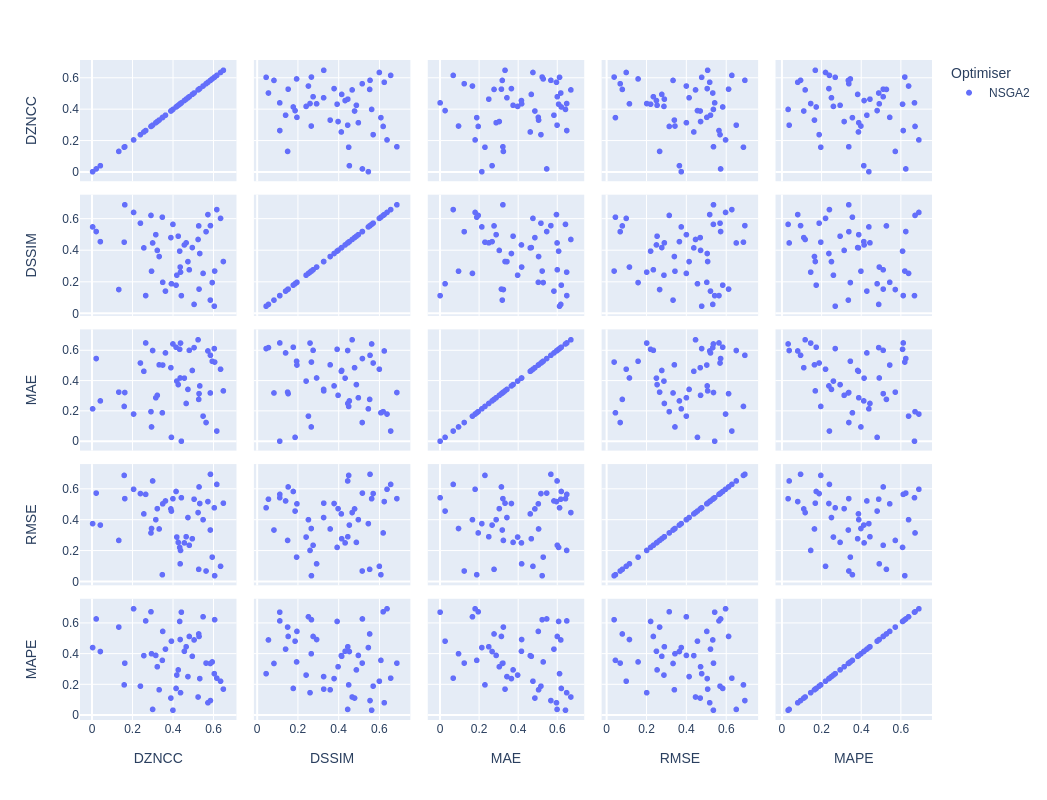

In [35]:
fig = px.scatter_matrix(df_RL,
    dimensions=["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE"],
    color="Optimiser")

fig.update_layout(
    height=800,
    width=800
)

fig.show()

fig.write_image(output_path + "/RL-scatter_matrix.pdf", engine="kaleido")
fig.write_image(output_path + "/RL-scatter_matrix.png", engine="kaleido")

/home/franck/anaconda3/envs/gVXR2CIL/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



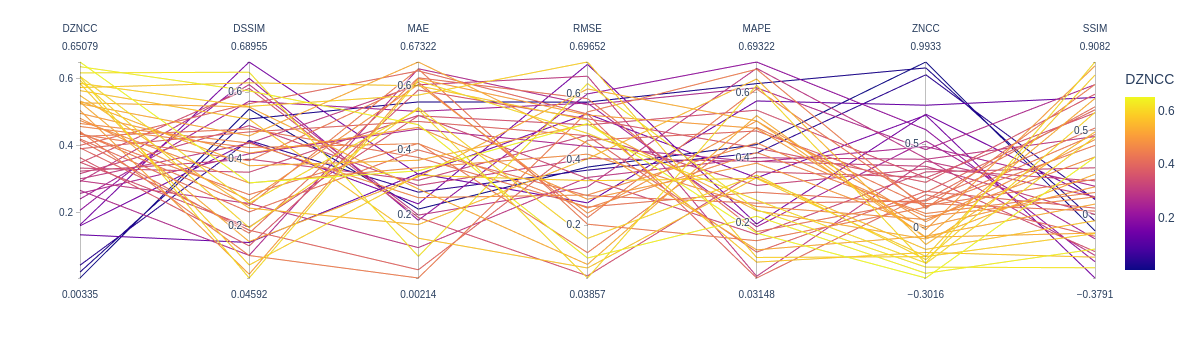

In [36]:
fig = px.parallel_coordinates(df_RL[["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE", "ZNCC", "SSIM"]], color="DZNCC")
fig.show()

fig.write_image(output_path + "/rl-parallel_coordinates.pdf", engine="kaleido")
fig.write_image(output_path + "/rl-parallel_coordinates.png", engine="kaleido")

In [37]:
df_AP = pd.DataFrame(data=np.append(res_ap.X, res_ap.F, axis=1),
                  columns=["cx", "cy", "MAE", "DZNCC", "RMSE", "MAPE", "DSSIM"])

df_AP["ZNCC"] = 1.0 - (df_AP["DZNCC"] * 2.0)
df_AP["SSIM"] = 1.0 - (df_AP["DSSIM"] * 2.0)

df_AP["Optimiser"] = "NSGA2"
df_AP.to_csv(output_path + "/AP-optimiser.csv")

/home/franck/anaconda3/envs/gVXR2CIL/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



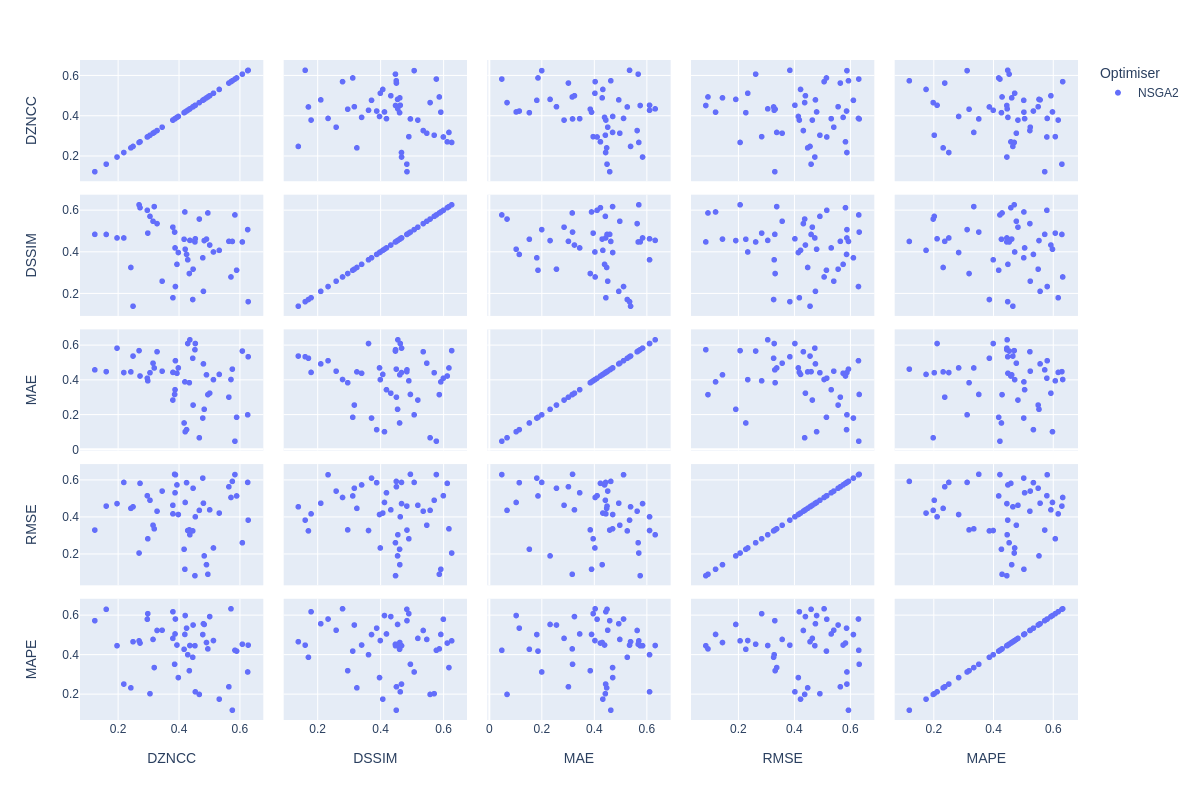

In [38]:
fig = px.scatter_matrix(df_AP,
    dimensions=["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE"],
    color="Optimiser")

fig.update_layout(
    height=800,
    width=800
)

fig.show()

fig.write_image(output_path + "/AP-scatter_matrix.pdf", engine="kaleido")
fig.write_image(output_path + "/AP-scatter_matrix.png", engine="kaleido")

/home/franck/anaconda3/envs/gVXR2CIL/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



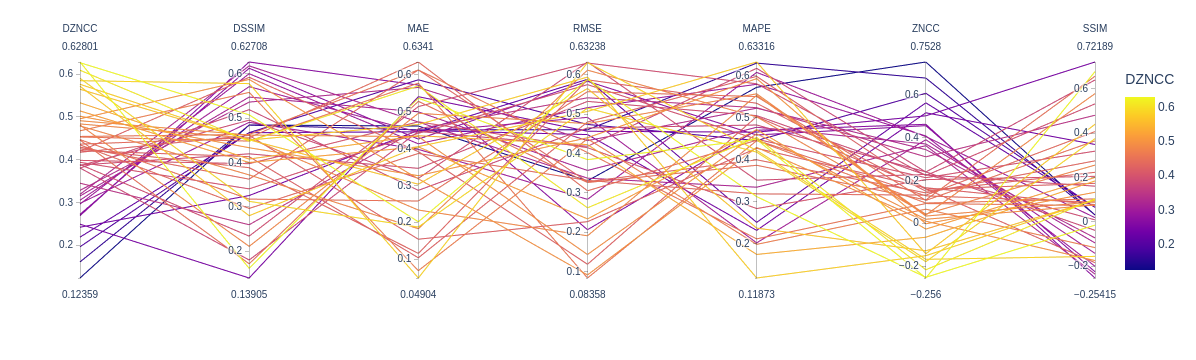

In [39]:
fig = px.parallel_coordinates(df_AP[["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE", "ZNCC", "SSIM"]], color="DZNCC")
fig.show()

fig.write_image(output_path + "/ap-parallel_coordinates.pdf", engine="kaleido")
fig.write_image(output_path + "/ap-parallel_coordinates.png", engine="kaleido")

Optimum c for right to left 108.50 , -349.19
Optimum c for anterior to posterior 580.54 , -15.34
I/O time: 0.000654 sec
Total time: 0.0158138 secs
I/O time: 0.001012 sec
Total time: 0.036376 secs
I/O time: 0.000761 sec
Total time: 0.0149291 secs
I/O time: 0.001114 sec
Total time: 0.0354581 secs
I/O time: 0.000737 sec
Total time: 0.013803 secs
I/O time: 0.000776 sec
Total time: 0.035989 secs
I/O time: 0.000850 sec
Total time: 0.015857 secs
I/O time: 0.000744 sec
Total time: 0.040617 secs
I/O time: 0.000751 sec
Total time: 0.0150311 secs
I/O time: 0.000687 sec
Total time: 0.0406702 secs
I/O time: 0.000749 sec
Total time: 0.016593 secs
I/O time: 0.000782 sec
Total time: 0.0336008 secs
I/O time: 0.000735 sec
Total time: 0.0155921 secs
I/O time: 0.363582 sec
Total time: 0.397472 secs
I/O time: 0.306727 sec
Total time: 0.321557 secs
I/O time: 0.001191 sec
Total time: 0.036732 secs
I/O time: 0.000749 sec
Total time: 0.0130079 secs
I/O time: 0.000864 sec
Total time: 0.0366449 secs
I/O time: 0.

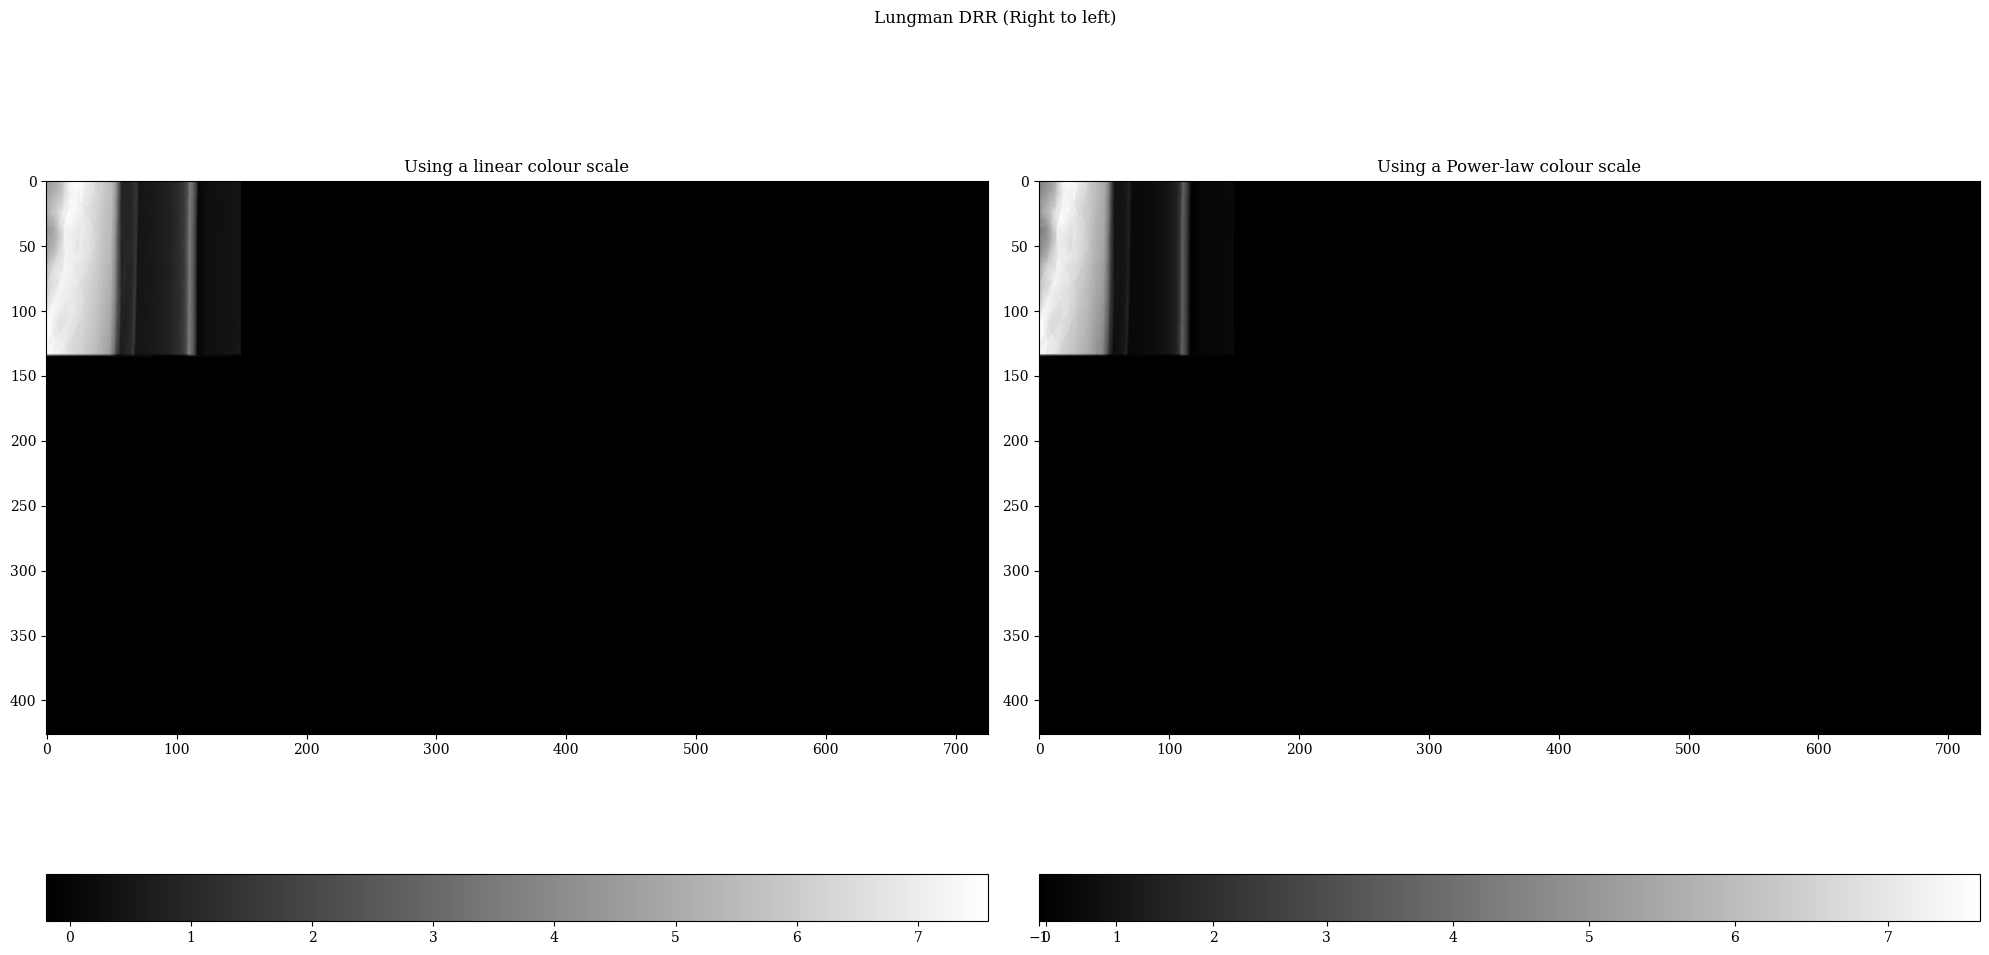

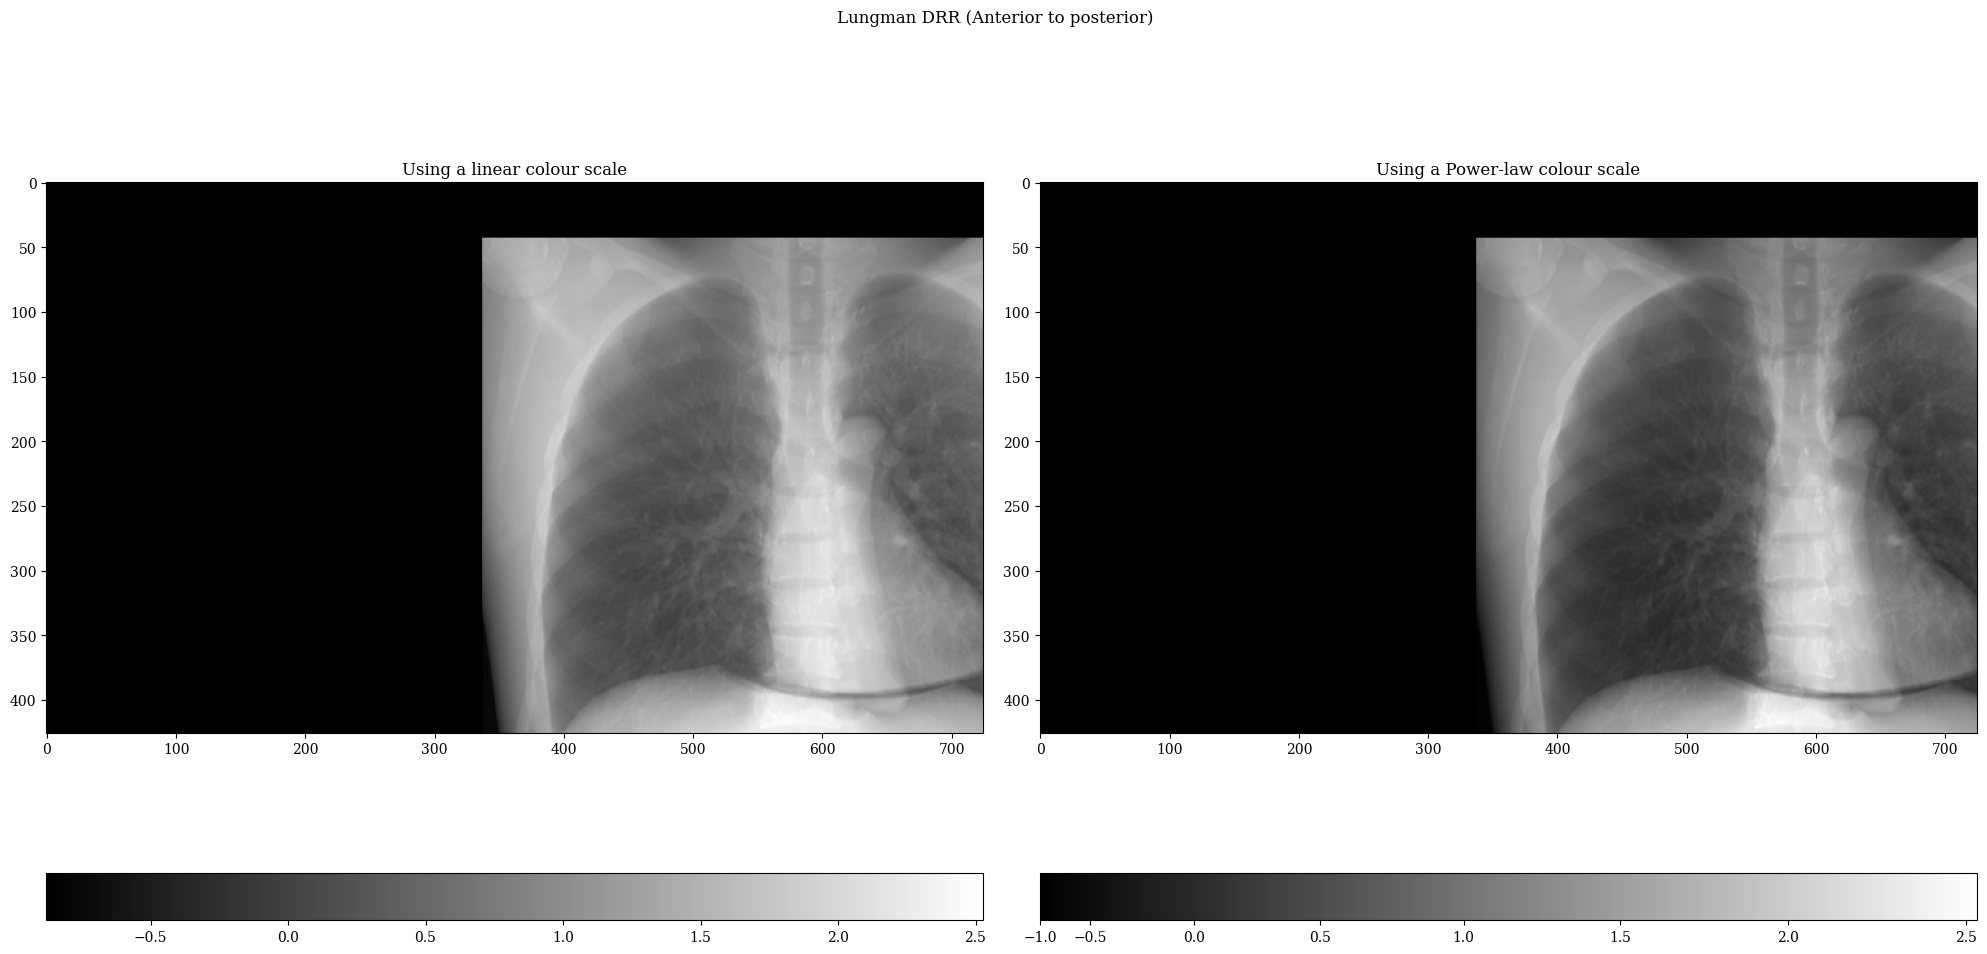

In [40]:
best_rl_id = np.argmin(res_rl.F[:,2])

best_ap_id = np.argmin(res_ap.F[:,2])

print("Optimum c for right to left", f"{res_rl.X[best_rl_id][0]:.2f}", ",", f"{ res_rl.X[best_rl_id][1]:.2f}")
print("Optimum c for anterior to posterior", f"{res_ap.X[best_ap_id][0]:.2f}", ",", f"{ res_ap.X[best_ap_id][1]:.2f}")

runtimes_drr_rl = []
runtimes_drr_ap = []

for i in range(50):
    start_time = datetime.datetime.now()

    DRR_RL = doLungmanDRRNumpy(1, 0, 0, 
                              res_rl.X[best_rl_id][0], res_rl.X[best_rl_id][1], 
                                "DRR_RL" 
                               );

    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes_drr_rl.append(delta_time.total_seconds() * 1000)

    start_time = datetime.datetime.now()

    DRR_AP = doLungmanDRRNumpy(0, -1, 0,
                                 res_ap.X[best_ap_id][0], res_ap.X[best_ap_id][1], 
                                    "DRR_AP" 
                                   );

    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes_drr_ap.append(delta_time.total_seconds() * 1000)

normImage(DRR_RL)
normImage(DRR_AP)
displayLinearPowerScales(DRR_RL,  "Lungman DRR (Right to left)", output_path + "/R_L_lungman_radiograph");
displayLinearPowerScales(DRR_AP,  "Lungman DRR (Anterior to posterior)", output_path + "/A_P_lungman_radiograph");

In [41]:
if (len(runtimes_drr_rl) > 0):
    runtimes_drr_rl_avg = round(np.mean(runtimes_drr_rl))
    runtimes_drr_rl_std = round(np.std(runtimes_drr_rl))
else:
    runtimes_drr_rl_avg = -1;
    runtimes_drr_rl_std = 0;

In [42]:
if (len(runtimes_drr_ap) > 0):
    runtimes_drr_ap_avg = round(np.mean(runtimes_drr_ap))
    runtimes_drr_ap_std = round(np.std(runtimes_drr_ap))
else:
    runtimes_drr_ap_avg = -1;
    runtimes_drr_ap_std = 0;

## Comparison the analytic simulation with the ground truth data

### Quantitative validation

Compute image metrics between the two simulated images:

1. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
2. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of ZNCC is 100%, and SSIM 1.

Note than the [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), is not used due to 1) zero values in the ground truth, and 2)  values are very smalls. Using the MAPE would lead to large errors for these reasons.

In [43]:
def compare(ref_image, test_image):

    ZNCC = np.mean((ref_image - ref_image.mean()) / ref_image.std() * (test_image - test_image.mean()) / test_image.std())
    print("ZNCC:", "{0:0.2f}".format(100 * ZNCC) + "%")

    offset1 = min(ref_image.min(), test_image.min())
    offset2 = 0.1 * (ref_image.max() - ref_image.min())
    MAPE = mape(ref_image.flatten() - offset1 + offset2, test_image.flatten() - offset1 + offset2)
    print("MAPE:", "{0:0.2f}".format(100 * MAPE) + "%")

    SSIM = ssim(ref_image, test_image, data_range=ref_image.max() - ref_image.min())
    print("SSIM:", "{0:0.2f}".format(SSIM))
    
    return ZNCC, MAPE, SSIM

**Medical orientations with plastimatch.**

R-L:
ZNCC: -16.73%
MAPE: 62.20%
SSIM: 0.04

A-P:
ZNCC: 9.13%
MAPE: 93.17%
SSIM: 0.05


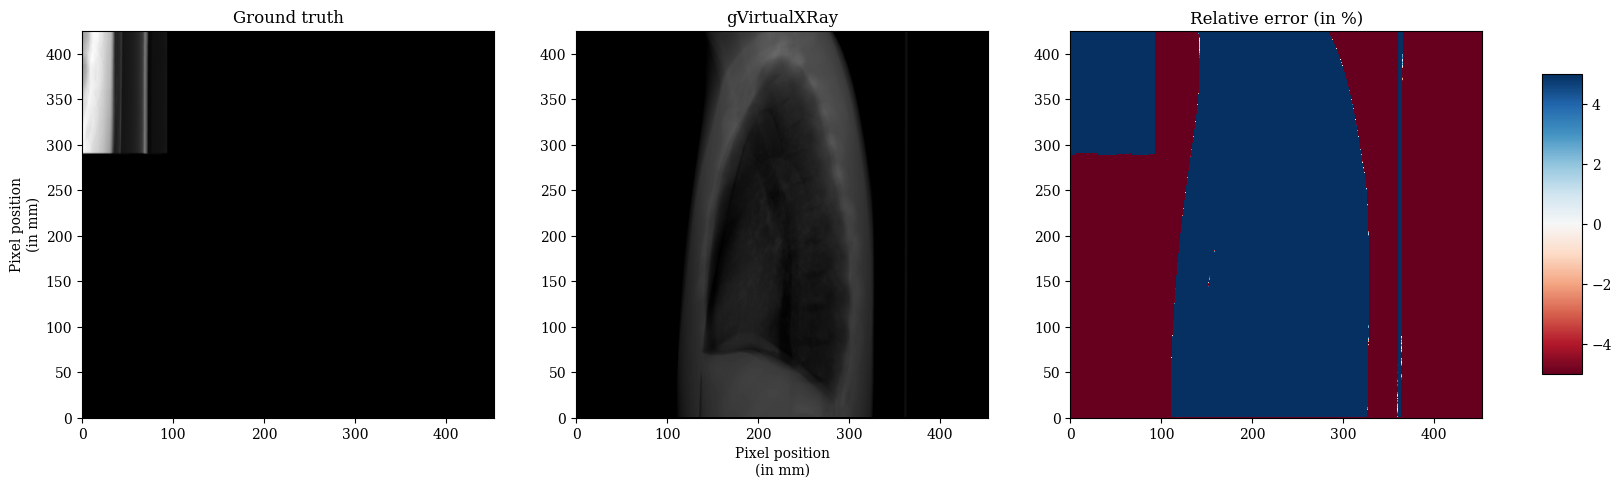

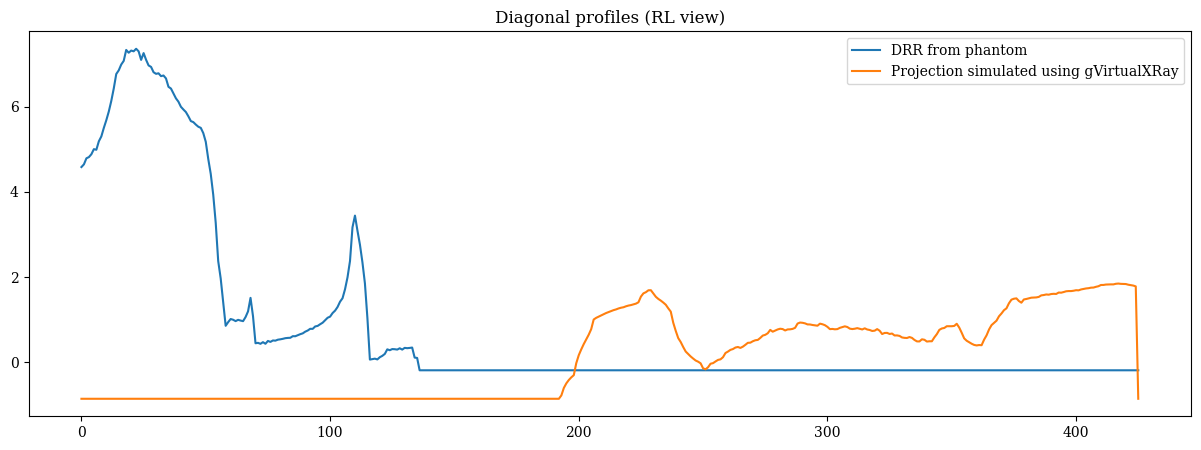

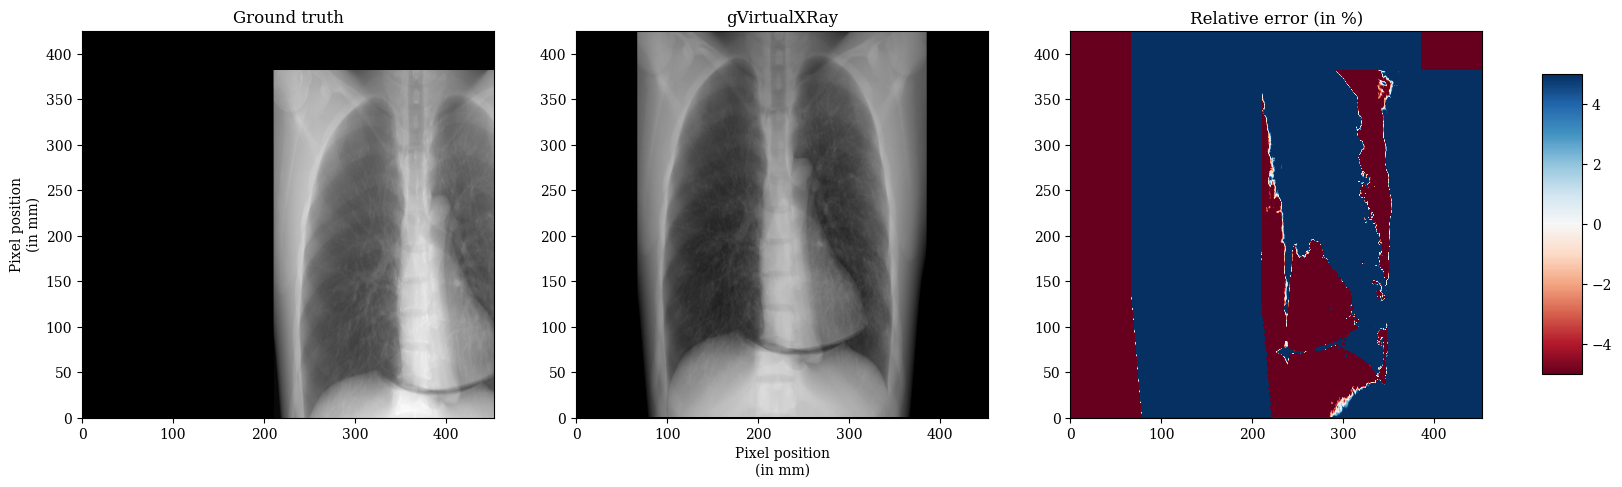

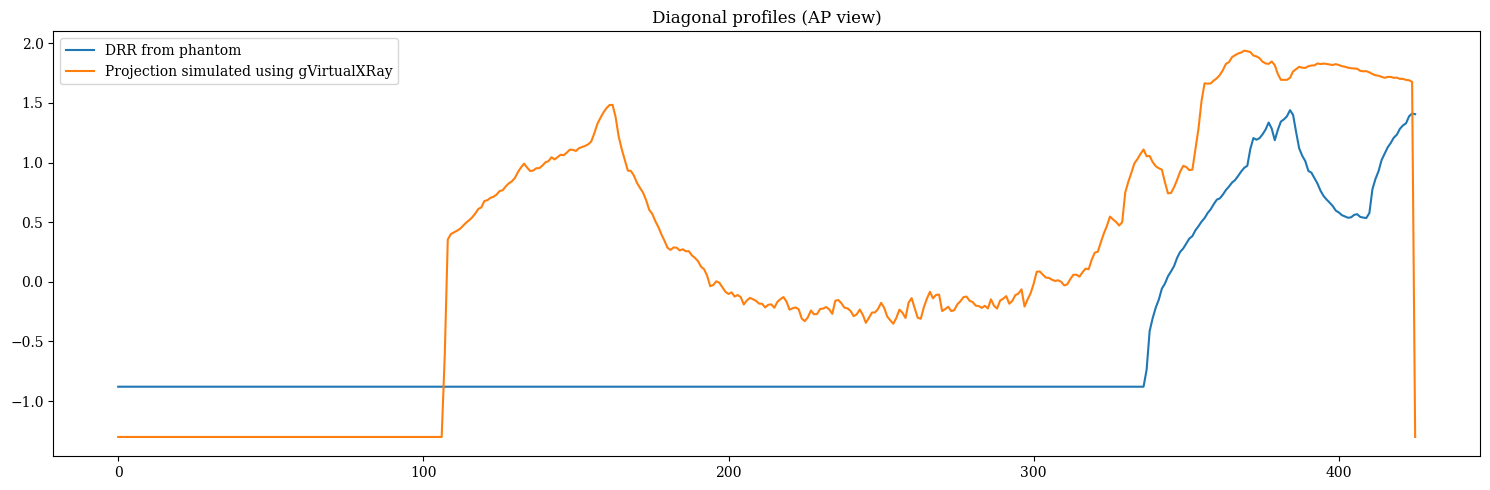

In [44]:
spacing = json2gvxr.params["Detector"]["Spacing"]

print('R-L:')
ref_proj = DRR_RL
test_proj = minus_log_proj_rl
ZNCC_DRR_RL, MAPE_DRR_RL, SSIM_DRR_RL = compare(ref_proj, test_proj)
fullCompareImages(ref_proj,
                  test_proj,
                  "gVirtualXRay",
                  output_path + "/lungman-compare-projs-plastimatch-rl",
                  spacing,
                  False,
                  ref_proj.min(), ref_proj.max())

ref_diag = np.diag(ref_proj)
test_diag = np.diag(test_proj)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles (RL view)")

ax.plot(ref_diag, label="DRR from phantom")
ax.plot(test_diag, label="Projection simulated using gVirtualXRay")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.legend()

plt.savefig(output_path + "/lungman-profiles-RL.pdf", bbox_inches = 'tight')
plt.savefig(output_path + "/lungman-profiles-RL.png", bbox_inches = 'tight')

print('\nA-P:')

ref_proj = DRR_AP
test_proj = minus_log_proj_ap
ZNCC_DRR_AP, MAPE_DRR_AP, SSIM_DRR_AP = compare(ref_proj, test_proj)
fullCompareImages(ref_proj,
                  test_proj,
                  "gVirtualXRay",
                  output_path + "/lungman-compare-projs-plastimatch-ap",
                  spacing,
                  False,
                  ref_proj.min(), ref_proj.max())

ref_diag = np.diag(ref_proj)
test_diag = np.diag(test_proj)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles (AP view)")

ax.plot(ref_diag, label="DRR from phantom")
ax.plot(test_diag, label="Projection simulated using gVirtualXRay")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.legend()

plt.tight_layout()

plt.savefig(output_path + "/lungman-profiles-AP.pdf", bbox_inches = 'tight')
plt.savefig(output_path + "/lungman-profiles-AP.png", bbox_inches = 'tight')

Print a row of the table for the paper

In [45]:
print("Lungman AP view & Plastimatch DRR & " + 
      "{0:0.2f}".format(100 * MAPE_DRR_AP) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_DRR_AP) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_DRR_AP) + "    &    $" +
      str(DRR_AP.shape[1]) + " \\times " + str(DRR_AP.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " + str(runtimes_drr_ap_avg) + " \\pm " + str(runtimes_drr_ap_std) + "    & " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Lungman AP view & Plastimatch DRR & 93.17\%    &    9.13\%    &    0.05    &    $725 \times 426$    &    27756160    &    413 \pm 56    & $-1 \pm 0$ \\


In [46]:
print("Lungman RL view & Plastimatch DRR & " + 
      "{0:0.2f}".format(100 * MAPE_DRR_RL) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_DRR_RL) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_DRR_RL) + "    &    $" +
      str(DRR_AP.shape[1]) + " \\times " + str(DRR_AP.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " + str(runtimes_drr_rl_avg) + " \\pm " + str(runtimes_drr_rl_std) + "    & " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Lungman RL view & Plastimatch DRR & 62.20\%    &    -16.73\%    &    0.04    &    $725 \times 426$    &    27756160    &    393 \pm 44    & $-1 \pm 0$ \\


# All done

Destroy the window

In [47]:
gvxr.destroyAllWindows()

Wed Dec 21 13:37:16 2022 ---- Destroy all the windows
Wed Dec 21 13:37:16 2022 ---- Destroy window 0(0x55a4ee1d0f10)
